### 1．インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from urllib.request import urlopen
import optuna.integration.lightgbm as lgb_o

### 1.1　クラス

In [2]:
# 訓練データと出馬表データを加工する抽象クラス
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame()
        # preprocessing後の変数
        self.data_p = pd.DataFrame()
        # horse_resultsをmergeした後の変数
        self.data_h = pd.DataFrame()
        # pedsをmergeした後の変数
        self.data_pe = pd.DataFrame()
        # カテゴリ変数化した後の変数
        self.data_c = pd.DataFrame()
        
    # 馬の過去成績データの追加
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
            
    # 血統データ追加
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds, left_on='horse_id', right_index=True, how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds):
            print('scrape peds at horse_id_list "no_peds"')
    
    # カテゴリ変数の処理
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        # ラベルエンコーディング(horse_id, jockey_idを0始まりの整数に変換)
        # horse_id
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        # jockey_id
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        # horse_id, jockey_idをcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        # そのほかのカテゴリ変数をcategory型に変換してからダミー変数化
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])  
        self.data_c = df

# 予測に使う出馬表データを加工するクラス
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
    
    @classmethod
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = f'https://race.netkeiba.com/race/shutuba.html?race_id={race_id}'
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            # race_data
            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all('td', attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            df['horse_id'] = horse_id_list

            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all('td', attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        
        return cls(data)
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()
        
        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df['馬体重(増減)'] != '--']
        df['体重'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].astype(int)
        
        # 日付をdatetime型に変更
        df['date'] = pd.to_datetime(df['date'])

        # データをint, floatに変換
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

    
        # 必要な列だけにする
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather', 'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢', '体重', '体重変化']]

        self.data_p = df.rename(columns={'枠': '枠番'})

# 訓練に使う過去レースデータを加工するクラス
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        # race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[0]

                html = requests.get(url)
                html.encoding = 'EUC-JP'
                soup = BeautifulSoup(html.text, 'html.parser')

                # 天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                texts = (
                    soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[0].text
                    + soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ['芝', 'ダート']:
                        df['race_type'] = [text] * len(df)
                    if '障' in text:
                        df['race_type'] = ['障害'] * len(df)
                    if 'm' in text:
                        df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                    if text in ['良', '稍重', '重', '不良']:
                        df['ground_state'] = [text] * len(df)
                    if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                        df['weather'] = [text] * len(df)
                    if '年' in text:
                        df['date'] = [text] * len(df)

                # 馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
                for a in horse_a_list:
                    horse_id = re.findall(r'\d+', a['href'])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
                for a in jockey_a_list:
                    jockey_id = re.findall(r'\d+', a['href'])
                    jockey_id_list.append(jockey_id[0])
                df['horse_id'] = horse_id_list
                df['jockey_id'] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
            # 存在しないrace_idを飛ばす
            except IndexError:
                continue
            # wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            # Jupyterで停止ボタンを押した時の対処
            except:
                break

        # pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df = df[~(df['着順'].astype(str).str.contains('\D'))]
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].astype(int)

        # 不要な列を削除
        df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手', '単勝', '人気', '着順'], axis=1, inplace=True)

        df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

        self.data_p = df
    
    # カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])        
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

# 馬の過去成績データを処理するクラス
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過']]
        self.preprocessing()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                time.sleep(1)
                url = f'https://db.netkeiba.com/horse/{horse_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[3]
                # 受賞歴がある馬の場合、4番目に受賞歴テーブルが来るため、5番目のデータを取得する
                if df.columns[0] == '受賞歴':
                    df = pd.read_html(url)[4]
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])
        
        return horse_results_df
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        # 1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x < 0 else x)
                                            
        # レース展開データ
        def corner(x, n):
            if type(x) != str:
                return x
            # n=1: 最初のコーナー位置、n=4: 最終コーナー位置
            if n == 1:
                return int(re.findall(r'\d+', x)[0])
            if n == 4:
                return int(re.findall(r'\d+', x)[-1])
                                            
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
                            
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金', '着差', 'first_corner', 'final_corner', 'final_to_rank', 'first_to_rank', 'first_to_final']].mean()
        rename_columns = average.rename(columns={'着順': f'着順_{n_samples}R',
                                                 '賞金': f'賞金_{n_samples}R',
                                                 '着差': f'着差_{n_samples}R',
                                                 'first_corner': f'first_corner_{n_samples}R',
                                                 'final_corner': f'final_corner_{n_samples}R',
                                                 'final_to_rank': f'final_to_rank_{n_samples}R',
                                                 'first_to_rank': f'first_to_rank_{n_samples}R',
                                                 'first_to_final': f'first_to_final_{n_samples}R'
                                                })
                                                 
        return rename_columns
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df

# 血統データを処理するクラス
class Peds:
    def __init__(self, peds):
        self.peds = peds
        # LabelEncodingしてcategory型にした変数
        self.peds_e = pd.DataFrame()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # 血統データを取り出す
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = f'https://db.netkeiba.com/horse/ped/{horse_id}'
                df = pd.read_html(url)[0]

                # 重複を削除して1列のSeries型データに治す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()

                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                peds_dict[horse_id] = ped.reset_index(drop=True)
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # 列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
        
        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

# 払い戻しデータを加工するクラス
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'

                # 複勝やワイドなどが区切られてしまうため、改行コードを文字列に変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')            
                dfs = pd.read_html(html)

                # dfsの2番目に単勝～馬連、3番目にワイド～3連単がある
                df = pd.concat([dfs[1], dfs[2]])
                
                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        
        return return_tables_df
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho

# 予測モデルを評価するクラス
class ModelEvaluator:
    def __init__(self, model, return_tables_path, std=True):
        self.model = model
        self.fukusho = Return.read_pickle([return_tables_path]).fukusho
        self.tansho = Return.read_pickle([return_tables_path]).tansho
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x)[:, 1], index=x.index)
        if self.std:
            # 標準化
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win'] == df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return_proper(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        # 単勝適性回収値を計算
        return_rate = len(df.query('win == 馬番')) / (100 / df['return']).sum()
        
        return n_bets, return_rate

### 1.2　関数

In [3]:
# 時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

# 回収率を計算する関数
def gain(return_func, x, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, return_rate = return_func(x, threshold)
        if n_bets > lower:
            gain[n_bets] = return_rate
    return pd.Series(gain)

# 重複のないデータを作成する関数
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

### 2．前処理

In [4]:
r = Results.read_pickle(['results.pickle'])

# 前処理
r.preprocessing()

# 馬の過去成績データの追加
hr = HorseResults.read_pickle(['horse_results.pickle'])
r.merge_horse_results(hr)

# 5世代分の血統データの追加
p = Peds.read_pickle(['peds.pickle'])
p.encode()
r.merge_peds(p.peds_e)

# カテゴリ変数の処理
r.process_categorical()

### 3．予測

In [5]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [6]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [7]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [8]:
# gain_baseline = gain(me.tansho_return, X_test)
# gain_baseline.to_pickle('gain_baseline.pickle')

In [9]:
gain_baseline = pd.read_pickle('gain_baseline.pickle')

#### 4．単勝適性回収値
常に払戻額が一定になるように単勝で賭けた場合の回収率<br>
払戻額が常に1万円になるように賭けてみる

賭けた金額<br>
x円賭けるとすると<br>
$$
各馬番の単勝オッズ \times \frac{x}{100} = 10000 \\
\therefore \quad x = \frac{100 \times 10000}{各馬番の単勝オッズ}
$$

回収率 = 払戻額 / 賭けた金額

In [10]:
# gain_proper = gain(me.tansho_return_proper, X_test)
# gain_proper.to_pickle('gain_proper.pickle')

In [11]:
gain_proper = pd.read_pickle('gain_proper.pickle')

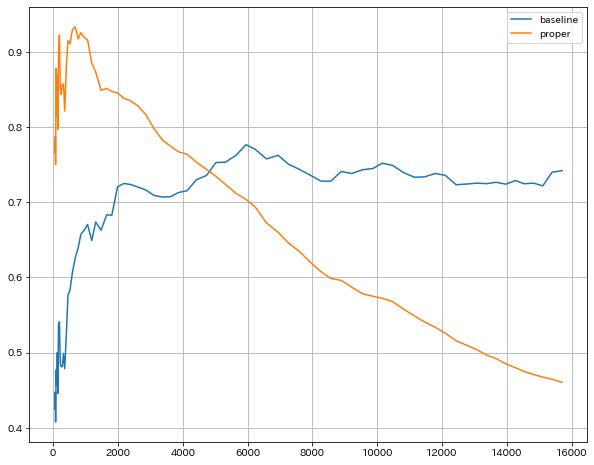

In [12]:
plt.figure(figsize=(10, 8))
gain_baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

### 5．Optuna

In [13]:
# 訓練データ、検証データ、テストデータに分ける
train, test = split_data(r.data_c)
train, valid = split_data(train)

In [14]:
# 説明変数と目的変数に分ける
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [15]:
# データセットの作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# チューニング実行
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-03-21 16:54:27,807] A new study created in memory with name: no-name-7d902950-c744-4ff4-af1c-0dc00275a1ad
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.466952:  14%|#4        | 1/7 [00:04<00:27,  4.64s/it]

Early stopping, best iteration is:
[66]	valid_0's binary_logloss: 0.424361	valid_1's binary_logloss: 0.466952
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.464526:  29%|##8       | 2/7 [00:08<00:22,  4.52s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.421952	valid_1's binary_logloss: 0.464526
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.464526:  43%|####2     | 3/7 [00:13<00:17,  4.47s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.418812	valid_1's binary_logloss: 0.466277
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.464526:  57%|#####7    | 4/7 [00:18<00:13,  4.60s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.419338	valid_1's binary_logloss: 0.465728
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.464526:  71%|#######1  | 5/7 [00:22<00:08,  4.38s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.428381	valid_1's binary_logloss: 0.465987
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.464526:  86%|########5 | 6/7 [00:25<00:04,  4.25s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.427506	valid_1's binary_logloss: 0.465223
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.426837	valid_1's binary_logloss: 0.465527
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:   5%|5         | 1/20 [00:04<01:20,  4.23s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.402786	valid_1's binary_logloss: 0.466294
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  10%|#         | 2/20 [00:10<01:28,  4.93s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.327383	valid_1's binary_logloss: 0.470859
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  15%|#5        | 3/20 [00:15<01:24,  4.98s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.370019	valid_1's binary_logloss: 0.468315
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  20%|##        | 4/20 [00:21<01:24,  5.31s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.332146	valid_1's binary_logloss: 0.472439
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  25%|##5       | 5/20 [00:27<01:19,  5.30s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.376912	valid_1's binary_logloss: 0.467121
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  30%|###       | 6/20 [00:31<01:09,  4.96s/it]

Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.387743	valid_1's binary_logloss: 0.46803
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  35%|###5      | 7/20 [00:36<01:04,  4.94s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.370945	valid_1's binary_logloss: 0.467077
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  40%|####      | 8/20 [00:43<01:07,  5.58s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.322659	valid_1's binary_logloss: 0.472352
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  45%|####5     | 9/20 [00:49<01:03,  5.73s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.330395	valid_1's binary_logloss: 0.470961
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464526:  50%|#####     | 10/20 [00:54<00:54,  5.45s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.375845	valid_1's binary_logloss: 0.470205
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464100:  55%|#####5    | 11/20 [00:57<00:43,  4.80s/it]

Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.438021	valid_1's binary_logloss: 0.4641
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.464972	valid_1's binary_logloss: 0.468806
[200]	valid_0's binary_logloss: 0.455146	valid_1's binary_logloss: 0.466145


num_leaves, val_score: 0.464100:  60%|######    | 12/20 [01:02<00:37,  4.73s/it]

Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.454338	valid_1's binary_logloss: 0.46601
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.478073	valid_1's binary_logloss: 0.476243
[200]	valid_0's binary_logloss: 0.474438	valid_1's binary_logloss: 0.474258
[300]	valid_0's binary_logloss: 0.472169	valid_1's binary_logloss: 0.472868
[400]	valid_0's binary_logloss: 0.470487	valid_1's binary_logloss: 0.471993
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.470242	valid_1's binary_logloss: 0.471842

num_leaves, val_score: 0.464100:  65%|######5   | 13/20 [01:06<00:33,  4.77s/it]


Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.478073	valid_1's binary_logloss: 0.476243
[200]	valid_0's binary_logloss: 0.474438	valid_1's binary_logloss: 0.474258
[300]	valid_0's binary_logloss: 0.472169	valid_1's binary_logloss: 0.472868
[400]	valid_0's binary_logloss: 0.470487	valid_1's binary_logloss: 0.471993
Early stopping, best iteration is:
[417]	valid_0's binary_logloss: 0.470242	valid_1's binary_logloss: 0.471842

num_leaves, val_score: 0.464100:  70%|#######   | 14/20 [01:11<00:28,  4.82s/it]


Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464100:  75%|#######5  | 15/20 [01:16<00:23,  4.63s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.417345	valid_1's binary_logloss: 0.465553
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464100:  80%|########  | 16/20 [01:20<00:18,  4.51s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.423163	valid_1's binary_logloss: 0.465094
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464100:  85%|########5 | 17/20 [01:24<00:13,  4.49s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.415063	valid_1's binary_logloss: 0.465971
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464100:  90%|######### | 18/20 [01:31<00:10,  5.06s/it]

Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.363679	valid_1's binary_logloss: 0.469327
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.464100:  95%|#########5| 19/20 [01:35<00:04,  4.76s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.426118	valid_1's binary_logloss: 0.464993
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.34734	valid_1's binary_logloss: 0.470134
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  10%|#         | 1/10 [00:03<00:27,  3.09s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.435058	valid_1's binary_logloss: 0.467213
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  20%|##        | 2/10 [00:06<00:25,  3.16s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.448835	valid_1's binary_logloss: 0.467719
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  30%|###       | 3/10 [00:09<00:21,  3.06s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.441384	valid_1's binary_logloss: 0.468346
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  40%|####      | 4/10 [00:12<00:18,  3.16s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.43887	valid_1's binary_logloss: 0.466691
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  50%|#####     | 5/10 [00:16<00:17,  3.43s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.431301	valid_1's binary_logloss: 0.464784
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  60%|######    | 6/10 [00:19<00:13,  3.25s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.446791	valid_1's binary_logloss: 0.467318
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  70%|#######   | 7/10 [00:23<00:10,  3.48s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.440726	valid_1's binary_logloss: 0.467991
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  80%|########  | 8/10 [00:26<00:06,  3.40s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.438119	valid_1's binary_logloss: 0.465427
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.464100:  90%|######### | 9/10 [00:30<00:03,  3.59s/it]

[100]	valid_0's binary_logloss: 0.425623	valid_1's binary_logloss: 0.465603
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.427683	valid_1's binary_logloss: 0.465439
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.464100:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.438771	valid_1's binary_logloss: 0.466115
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.463877:  17%|#6        | 1/6 [00:03<00:19,  3.91s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464078
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463877
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.463877:  33%|###3      | 2/6 [00:07<00:15,  3.79s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.434827	valid_1's binary_logloss: 0.465132
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.463877:  50%|#####     | 3/6 [00:11<00:11,  3.84s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.432085	valid_1's binary_logloss: 0.464676
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.463877:  67%|######6   | 4/6 [00:15<00:07,  3.88s/it]

[100]	valid_0's binary_logloss: 0.425368	valid_1's binary_logloss: 0.464593
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.425794	valid_1's binary_logloss: 0.464547
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.463877:  83%|########3 | 5/6 [00:19<00:04,  4.09s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.43201	valid_1's binary_logloss: 0.464046
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463877:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.432814	valid_1's binary_logloss: 0.464145
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463877:   5%|5         | 1/20 [00:03<01:07,  3.54s/it]

[100]	valid_0's binary_logloss: 0.426156	valid_1's binary_logloss: 0.464207
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.429938	valid_1's binary_logloss: 0.464108
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  10%|#         | 2/20 [00:07<01:05,  3.65s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464063
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463862
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  15%|#5        | 3/20 [00:11<01:06,  3.90s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464065
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463865
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  20%|##        | 4/20 [00:16<01:03,  3.99s/it]

[100]	valid_0's binary_logloss: 0.426482	valid_1's binary_logloss: 0.464127
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.427726	valid_1's binary_logloss: 0.464023
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  25%|##5       | 5/20 [00:19<00:57,  3.83s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464067
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463867
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  30%|###       | 6/20 [00:23<00:54,  3.92s/it]

Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.433961	valid_1's binary_logloss: 0.464113
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  35%|###5      | 7/20 [00:27<00:51,  3.93s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.441437	valid_1's binary_logloss: 0.464596
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463862:  40%|####      | 8/20 [00:30<00:44,  3.69s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.439675	valid_1's binary_logloss: 0.465266
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.428234	valid_1's binary_logloss: 0.464407


regularization_factors, val_score: 0.463862:  45%|####5     | 9/20 [00:36<00:45,  4.16s/it]

Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.418768	valid_1's binary_logloss: 0.463951
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  50%|#####     | 10/20 [00:39<00:40,  4.08s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.46406
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.46386
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  55%|#####5    | 11/20 [00:43<00:35,  3.98s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.431424	valid_1's binary_logloss: 0.464001
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  60%|######    | 12/20 [00:47<00:32,  4.00s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464074
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463874
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  65%|######5   | 13/20 [00:51<00:27,  3.96s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464064
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463863
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  70%|#######   | 14/20 [00:54<00:22,  3.69s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.439671	valid_1's binary_logloss: 0.465266
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  75%|#######5  | 15/20 [00:59<00:19,  3.94s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464072
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463871
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  80%|########  | 16/20 [01:03<00:15,  3.94s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464068
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463867
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463860:  85%|########5 | 17/20 [01:06<00:11,  3.81s/it]

[100]	valid_0's binary_logloss: 0.425951	valid_1's binary_logloss: 0.464065
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.42946	valid_1's binary_logloss: 0.463864
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463271:  90%|######### | 18/20 [01:10<00:07,  3.79s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.437045	valid_1's binary_logloss: 0.463271
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.463271:  95%|#########5| 19/20 [01:14<00:03,  3.83s/it]

[100]	valid_0's binary_logloss: 0.426057	valid_1's binary_logloss: 0.464731
Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.426863	valid_1's binary_logloss: 0.464532
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.463271:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	valid_0's binary_logloss: 0.432575	valid_1's binary_logloss: 0.463465
Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.434762	valid_1's binary_logloss: 0.463306
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.432611	valid_1's binary_logloss: 0.463319


min_data_in_leaf, val_score: 0.462717:  20%|##        | 1/5 [00:04<00:17,  4.46s/it]

Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.42386	valid_1's binary_logloss: 0.462717
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.462717:  40%|####      | 2/5 [00:08<00:12,  4.24s/it]

Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.439106	valid_1's binary_logloss: 0.463853
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.462717:  60%|######    | 3/5 [00:11<00:08,  4.04s/it]

[100]	valid_0's binary_logloss: 0.432643	valid_1's binary_logloss: 0.464028
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.434194	valid_1's binary_logloss: 0.463972
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.462717:  80%|########  | 4/5 [00:15<00:03,  4.00s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.436741	valid_1's binary_logloss: 0.463819
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.431907	valid_1's binary_logloss: 0.463367


min_data_in_leaf, val_score: 0.462717: 100%|##########| 5/5 [00:19<00:00,  3.99s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.429897	valid_1's binary_logloss: 0.463212


1．あるハイパーパラメータを使って、lgb_trainで学習<br>
2．そのモデルを使ってlgb_validで検証<br>
3．検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習<br>
4．2～3を繰り返す

In [16]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 1.659486213190481e-06,
 'lambda_l2': 9.314290151707889,
 'num_leaves': 22,
 'feature_fraction': 0.484,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25}

In [17]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [18]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, feature_fraction=0.484,
               feature_pre_filter=False, lambda_l1=1.659486213190481e-06,
               lambda_l2=9.314290151707889, min_child_samples=25, num_leaves=22,
               objective='binary', random_state=100)

In [19]:
me2 = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [20]:
me2.feature_importance(X_test)

,features,importance
4,jockey_id,133
10,賞金_5R,107
7,体重,80
3,horse_id,74
9,着順_5R,65
5,course_len,61
26,賞金_allR,49
1,馬番,46
19,着差_9R,46
8,体重変化,44


In [21]:
# gain_optuna = gain(me2.tansho_return_proper, X_test)
# gain_optuna.to_pickle('gain_optuna.pickle')

In [22]:
gain_optuna = pd.read_pickle('gain_optuna.pickle')

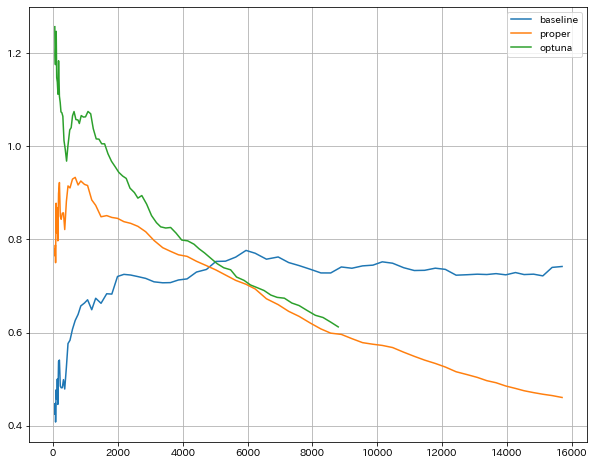

In [24]:
plt.figure(figsize=(10, 8))
gain_baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
gain_optuna.rename('optuna').plot(legend=True)
plt.grid()

In [25]:
gain_optuna.max()

1.2570086534300338